<a href="https://colab.research.google.com/github/Alihassan7726/Fine-tuning-BERT-for-semantic-sentence-pairs-classification/blob/main/Semantic_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=right> Fine-Tuning BERT using tensorflow and tf_hub</h2>
<h1 align=right> on semantic sentence pairs classification</h2>

In this project we'll see how to fine-tune BERT for sentence pairs classification problem using Tensorflow and tf_hub . 

The pre-trained BERT models are available at [tensorflow hub](https://tfhub.dev/). 

# Table of contents:
- **[Step 1]()**: Setting up TensorFlow and Colab Runtime
- **[Step 2]()**: Installing tensorflow Model garden pakage and other required dependencies 
- **[Step 3]()**: Importing libraires and defining BERT path URL
- **[Step 4]()**: Geting the dataset from TensorFlow Datasets
- **[Step 5]()**: Preprocessing Data using separate Tensorflow model 
- **[Step 6]()**: Applying preprocessing model on entire dataset using `.map` method
- **[Step 7]()**: Creating a TensorFlow Input Pipeline with `tf.data`
- **[Step 8]()**: Adding a Classification Head to the BERT `hub.KerasLayer` Execution
- **[Step 9]()**: Fine-Tuning BERT for sentence pairs Classification
- **[Step 10]()**: Evaluating Model performance visually 
- **[Step 11]()**: Exporting Model for Inference
- **[Step 12]()**: Saving and evaluating the BERT Model on new data

### Step 1: Setting up TensorFlow and Colab Runtime

Go to above menu bar and select `Runtime` then from Dropdown menu select `change runtime type` and then choose `GPU` from that to enable it . Lastly try to connect GPU with `Connect` button at upper right corner of notebook 

In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
!nvidia-smi

GPU is available
Thu Jul  1 03:23:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

### Step 2: Installing tensorflow Model garden pakage and other required dependencies 


You have to restart your kernel after executing below 3 cells by clicking on same `Runtime` menu and then choosing `Restart runtime`

In [ ]:
pip install -q -U tensorflow-text


     |████████████████████████████████| 4.3MB 31.2MB/s 


In [ ]:
# To create Adamw optimizor
!pip install -q tf-models-official


     |████████████████████████████████| 1.6MB 31.2MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 1.2MB 46.6MB/s 
     |████████████████████████████████| 358kB 60.8MB/s 
     |████████████████████████████████| 38.2MB 80kB/s 
     |████████████████████████████████| 215kB 57.9MB/s 
     |████████████████████████████████| 686kB 41.3MB/s 
     |████████████████████████████████| 645kB 40.9MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 


In [ ]:
pip install -U tfds-nightly


     |████████████████████████████████| 3.9MB 28.4MB/s 


### Step 3: Importing libraires and defining BERT path URL

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
from official.nlp import optimization  # to create AdamW optimizer
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
tf.get_logger().setLevel('ERROR')


In [ ]:
# Model URL
hub_bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
# Preprocessor URL
hub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


bert_preprocess = hub.load(hub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


### Step 4: Geting the dataset from TensorFlow Datasets
The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

- Number of labels: 2.

- Size of training dataset: 3668.
- Size of evaluation dataset: 408.
- Maximum sequence length of training and evaluation dataset: 128.

In [ ]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [ ]:
list(glue.keys())


[Split('train'), Split('validation'), Split('test')]

In [ ]:
info.features


FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names


['not_equivalent', 'equivalent']

In [ ]:
glue['train']

{'idx': <tf.Tensor: shape=(3668,), dtype=int32, numpy=array([1680, 1456, 3017, ..., 3682, 3619, 3624], dtype=int32)>,
 'label': <tf.Tensor: shape=(3668,), dtype=int64, numpy=array([0, 0, 1, ..., 1, 0, 1])>,
 'sentence1': <tf.Tensor: shape=(3668,), dtype=string, numpy=
 array([b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
        b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
        b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
        ...,
        b'Stack said he did no work for Triumph until 1999 , when a grand jury began investigating Silvester .',
        b'The giant rock was first observed on August 24 by Lincoln Near-Earth Asteroid Research Program , based in Socorro , New Mexico .',
        b"Two of Collins ' top assistants will consult with state police during the investigation and determine 

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


Each preprocessing model also provides a method, `.bert_pack_inputs(tensors, seq_length)`, which takes a list of tokens (like tok above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

In [ ]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


### Step 5: Preprocessing Data using separate Tensorflow model

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(hub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
sentence_features = ['my_input1', 'my_input2']
input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]
print(type(input_segments))
print(input_segments)

<class 'list'>
[<KerasTensor: shape=(None,) dtype=string (created by layer 'my_input1')>, <KerasTensor: shape=(None,) dtype=string (created by layer 'my_input2')>]


In [ ]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['Range rover is luxury car']),
             np.array(['It can also be used for sports'])]
text_preprocessed = test_preprocess_model(test_text)

print('Type of output : ', type(text_preprocessed))
print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Type of output :  <class 'dict'>
Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2846 13631  2003  9542  2482   102  2009  2064  2036  2022  2109
  2005  2998   102     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0], shape=(16,), dtype=int32)


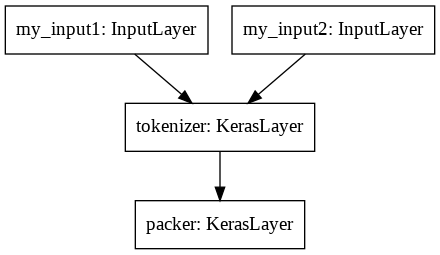

In [ ]:
tf.keras.utils.plot_model(test_preprocess_model)


### Step 6: Applying preprocessing model on entire dataset using `.map` method 
To apply the preprocessing in all the inputs from the dataset, we will use the `.map` function from the dataset. The result is then cached for performance.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

""" Here we will pass each inidividual Dataset like ['train','test','validation'] to function below 
    and this function will then applies the above TF preprocessing model on the provided inputs and 
    returns the Data ready for BERT input """
     
def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']), num_parallel_calls = AUTOTUNE)
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

### Step 7: Creating a TensorFlow Input Pipeline with `tf.data`

We need to initialize the input layers to only accept the text data values by 
providing each layer names of those fields otherwise we'll get error as we are passing the whole glue data including `idx` and `label` fields that are not acceptable by input layers . 


In [ ]:

epochs = 4
batch_size = 32
init_lr = 2e-5

print(f'Creating Data for BERT')

# Initializing Preprocessing model to only accept text fields as inputs
sentence_features = ['sentence1', 'sentence2']
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

# Running everything on CPU
with tf.device('/cpu:0'):
  # Train_data
  train_data, train_data_size = load_dataset_from_tfds( glue, info, 'train', batch_size, bert_preprocess_model )
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  # Valid data
  valid_data, no_of_valid_examples = load_dataset_from_tfds( glue, info, 'validation', batch_size, bert_preprocess_model )
  
print(train_data_size)
print(no_of_valid_examples)


Creating Data for BERT
3668
408


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):




In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
train_data

<PrefetchDataset shapes: ({input_type_ids: (None, 128), input_word_ids: (None, 128), input_mask: (None, 128)}, (None,)), types: ({input_type_ids: tf.int32, input_word_ids: tf.int32, input_mask: tf.int32}, tf.int64)>

### Step 8: Adding a Classification Head to the BERT `hub.KerasLayer`

<div align="right">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
max_seq_length = 128

# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name = "input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name = "input_type_ids")
  
  encoder_inputs = dict(input_word_ids = input_word_ids ,input_mask = input_mask,input_type_ids = input_type_ids  )
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" , trainable = True , name = 'encoder')
  
  outputs  = bert_layer(encoder_inputs)
  pooled_output = outputs["pooled_output"]      
  
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(2, activation=None, name="output")(drop)

  model = tf.keras.Model(
      inputs={
      'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
  },
      outputs=output)
  return model


In [ ]:
test_classifier_model = create_model()
bert_raw_result = test_classifier_model(text_preprocessed)
tf.sigmoid(bert_raw_result)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.15186939, 0.7111434 ]], dtype=float32)>

In [ ]:
np.argmax(tf.sigmoid(bert_raw_result))

1

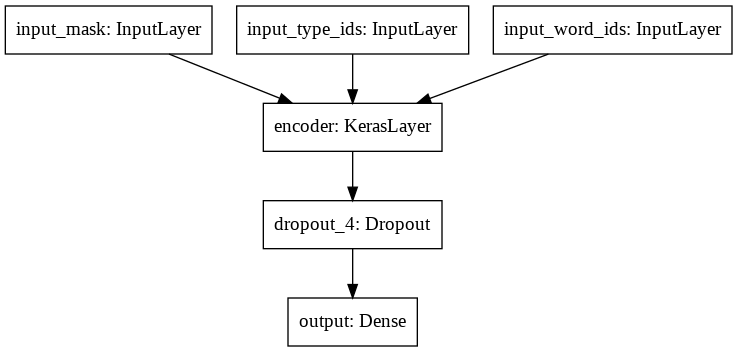

In [ ]:
tf.keras.utils.plot_model(test_classifier_model)


In [ ]:
# Setting configuration for model
def get_configuration():

  loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

  metric = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metric, loss

### Step 9: Fine-Tuning BERT for sentence pairs Classification
### Optimizor

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [`AdamW`](https://arxiv.org/abs/1711.05101).

For the learning rate (init_lr), we will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
## Instantiating the model
classifier_model = create_model()

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')


In [ ]:
# Compiling the model
metric, loss = get_configuration()

classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics = metric)
classifier_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
encoder (KerasLayer)            {'encoder_outputs':  109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

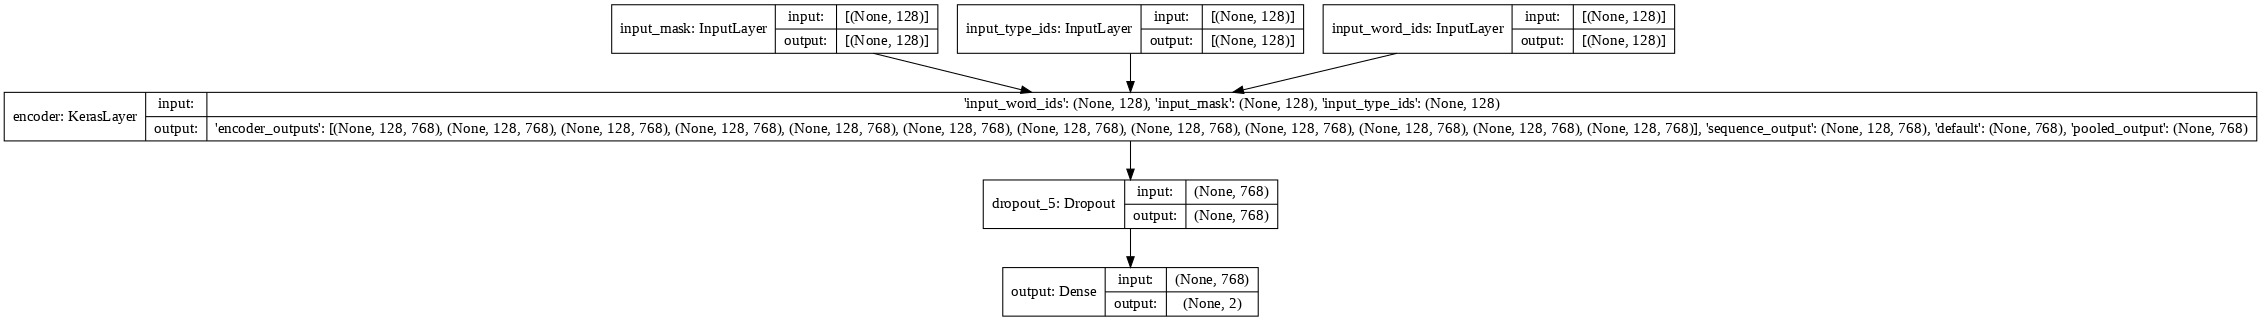

In [ ]:
tf.keras.utils.plot_model(model = classifier_model, show_shapes = True, dpi=76 )

In [ ]:
for text , labls in train_data.take(1):
  print(labls)

tf.Tensor([1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1], shape=(32,), dtype=int64)


In [ ]:
# Training the model

validation_steps = no_of_valid_examples // batch_size

history = classifier_model.fit(
      x=train_data,
      validation_data=valid_data,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Epoch 1/4
114/114 [==============================] - 104s 860ms/step - loss: 0.6999 - accuracy: 0.6277 - val_loss: 0.5268 - val_accuracy: 0.7578
Epoch 2/4
114/114 [==============================] - 97s 847ms/step - loss: 0.4899 - accuracy: 0.7610 - val_loss: 0.4889 - val_accuracy: 0.8047
Epoch 3/4
114/114 [==============================] - 97s 848ms/step - loss: 0.3667 - accuracy: 0.8448 - val_loss: 0.4536 - val_accuracy: 0.8333
Epoch 4/4
114/114 [==============================] - 97s 847ms/step - loss: 0.2702 - accuracy: 0.8873 - val_loss: 0.5136 - val_accuracy: 0.8411


### Step 10: Evaluating Model performance visually

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

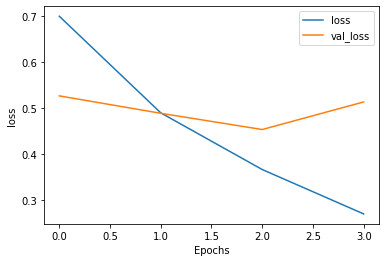

In [ ]:
plot_graphs(history,'loss')

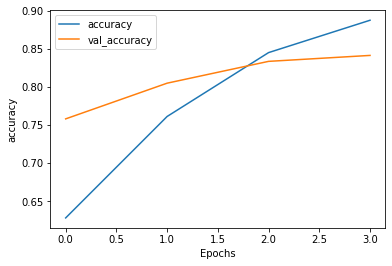

In [ ]:
plot_graphs(history,'accuracy')

## Step 11: Exporting Model for Inference

We will create a final model that has the preprocessing part and the fine-tuned BERT we've just created.

At inference time, preprocessing needs to be part of the model. Preprocessing is not just computation; it has its own resources (the vocab table) that must be attached to the Keras Model that is saved for export. This final assembly is what will be saved.

In [ ]:
tfds_name = 'glue/mrpc'
main_save_path = './my_models_BERT'

bert_type = hub_bert_url.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'
print(hub_bert_url)
print(bert_type)
print(saved_model_name)

saved_model_path = os.path.join(main_save_path, saved_model_name)
print(saved_model_path)

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
bert_en_uncased_L-12_H-768_A-12
glue_mrpc_bert_en_uncased_L-12_H-768_A-12
./my_models_BERT/glue_mrpc_bert_en_uncased_L-12_H-768_A-12


In [ ]:
bert_preprocess_model.inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'sentence1')>,
 <KerasTensor: shape=(None,) dtype=string (created by layer 'sentence2')>]

In [ ]:
preprocess_inputs = bert_preprocess_model.inputs
bert_preprocess_model(preprocess_inputs)

{'input_mask': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_4')>,
 'input_type_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_4')>,
 'input_word_ids': <KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'model_4')>}

In [ ]:
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
classifier_model(bert_encoder_inputs)

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'model_8')>

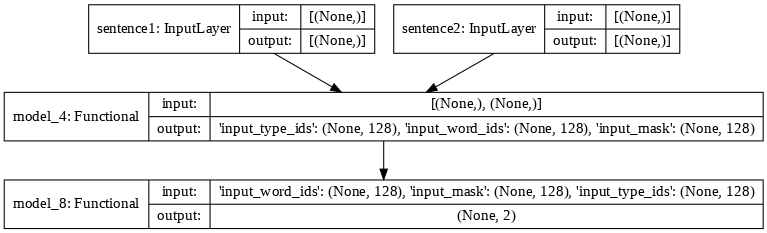

In [ ]:
# Merging both preprocessor and BERT model for inference
# As we can see in below plot the model can directly handle raw inputs and shows final results

bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)
tf.keras.utils.plot_model(model = model_for_export, show_shapes = True, dpi=76 )

In [ ]:
main_save_path = './my_models_BERT'
bert_type = hub_bert_url.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from GPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models_BERT/glue_mrpc_bert_en_uncased_L-12_H-768_A-12


### Step 12: Testing the model

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)


In [ ]:
glue['validation']

{'idx': <tf.Tensor: shape=(408,), dtype=int32, numpy=
 array([3155, 2472, 3584, 3523, 1782, 3741, 2301, 3130, 2894, 3013, 3237,
        1924, 3518, 2767, 3733, 1143, 1596, 3193,  813, 3989,   77, 2067,
        2343,  245, 3356, 2289, 3961, 1384, 2243,  404, 3457, 3261,  647,
        1306,   73, 4023,  674, 4020, 1967,  508,  613, 2439, 2051, 1036,
         620, 2932, 3281, 2124, 1436,  371, 1349, 2205, 1067, 3699,  594,
        1748,  417,  842, 2111,    9,  416,  222,  983, 2286, 1794, 3775,
        1755, 2396, 3575, 2394, 1218, 2655, 1069,  781, 3470, 1903, 2597,
        1102, 1080, 3531, 1567, 1746, 3153, 3210, 3423, 2547, 2777, 3783,
        3647,  990, 1592, 2350, 1076, 2828, 2713,  978,  686, 3167, 2876,
        3120, 1639, 2267,  354, 1540, 1371, 2656, 1646, 2834,  741, 3412,
        2352, 2469, 1326, 3889, 3887, 1745,  663, 2346, 1923, 1550, 1107,
        2297, 2381, 3668,  230, 3501, 1500,  540, 1203, 3773, 2249,  558,
        3615,  392,  897, 4053, 2539, 1489, 2698, 3382, 25

In [ ]:
print(sentence_features)
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  labels = [record['label']]
  return model_inputs , labels

['sentence1', 'sentence2']


In [ ]:
def evaluate(bert_result_class , test , label):
  print('sentence1:', test[0])
  print('sentence2:', test[1])
  print(tf.argmax(bert_result_class, axis=1)[0])    
  print("original results " , label)
  print('\n')
test_dataset = tf.data.Dataset.from_tensor_slices(glue['validation'])
for test_row,label in test_dataset.shuffle(1000).map(prepare).take(5):
  result = reloaded_model(list(test_row))
  evaluate(result, test_row , label)
  


sentence1: tf.Tensor([b'Cintas is battling efforts to unionize 17,000 of its workers and to let unions organize the workers by signing cards , rather than by a lengthy election process .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b"Cintas is battling efforts to unionize 17,000 of its workers and labor 's demands to let its workers organize by signing cards , rather than by a lengthy election process ."], shape=(1,), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
original results  tf.Tensor([1], shape=(1,), dtype=int64)


sentence1: tf.Tensor([b'But Virgin wants to operate Concorde on routes to New York , Barbados and Dubai .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'Branson said that his preference would be to operate a fully commercial service on routes to New York , Barbados and Dubai .'], shape=(1,), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
original results  tf.Tensor([1], shape=(1,), dtype=int64)


sentence1: tf.Tensor([b'In an unusual move , the U.S.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(glue['train'])
for train_row , label in train_dataset.shuffle(1000).map(prepare).take(5):
  result = reloaded_model(list(train_row))
  evaluate(result, train_row , label)


sentence1: tf.Tensor([b'Five more human cases of West Nile virus , were reported by the Mesa County Health Department on Wednesday .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'As of this week , 103 human West Nile cases in 45 counties had been reported to the health department .'], shape=(1,), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
original results  tf.Tensor([0], shape=(1,), dtype=int64)


sentence1: tf.Tensor([b'Scruggs , who did not testify , was cleared of a second charge of failing to provide her son with proper medical and psychological care .'], shape=(1,), dtype=string)
sentence2: tf.Tensor([b'The six-member jury cleared Scruggs of a second charge that accused her of failing to provide her son with proper medical and psychological care .'], shape=(1,), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
original results  tf.Tensor([1], shape=(1,), dtype=int64)


sentence1: tf.Tensor([b'BT said the combination would have an immediate impact on subscriptions wi